In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def new_cparameters(c2,c3,c4,c5,p):
    c2=c2*p
    c3=c3*p**3
    c4=p**4*(c4-3*c3**2/c2*(1-p))
    c5=p**5*(c5-(10*c4*c3/c2)*(1-p)+15*(c3**3/c2**2)*(1-p)**2)
    return c2,c3,c4,c5
def omega_s(phi_ex,beta,N,Ej,Ec,El,):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    p = El/(El+c2*Ej)
    c2,c3,c4,c5 = new_cparameters(c2,c3,c4,c5,p)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    
    sdim = 5
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
    Hs = omega_s * np.matmul(sd,s)+g3*x3 + g4*x4 + g5*x5 + 1e-9*x6 
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]/2/np.pi
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    return omega_s

def SNAIL(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    p = El/(El+c2*Ej)
    c2,c3,c4,c5 = new_cparameters(c2,c3,c4,c5,p)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    
    sdim = 5
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
#     anh = 12*(g4-5*g3**2/omega_s)
    Hs = omega_s * np.matmul(sd,s)+g3*x3 + g4*x4 + g5*x5 + 1e-9*x6 
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    cdim = 5
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int = g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact = energy[1]/2/np.pi
    return exact,omega_s, g3, g4, g5, anh, g_int
omega_sgrad = ad.grad(omega_s)

In [18]:
beta = 0.145
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
El = 64*2*np.pi
sweep_num = 500
phi_exs = np.linspace(0,0.5,sweep_num)
omega_c = 1.7*2*np.pi
g_intfa = 0.145
omega_ss =  np.zeros(len(phi_exs))
g3s=np.zeros(len(phi_exs))
g4s=np.zeros(len(phi_exs))
g5s=np.zeros(len(phi_exs))
anhs = np.zeros(len(phi_exs))
sders = np.zeros(len(phi_exs))
Es = np.zeros(len(phi_exs))
g_ints = np.zeros(len(phi_exs))
for i in range(sweep_num):
    Es[i] ,omega_ss[i],g3s[i],g4s[i],g5s[i],anhs[i],g_ints[i]=SNAIL(phi_exs[i],beta,N,Ej,Ec,El,omega_c,g_intfa)
    sders[i] = omega_sgrad(phi_exs[i],beta,N,Ej,Ec,El)

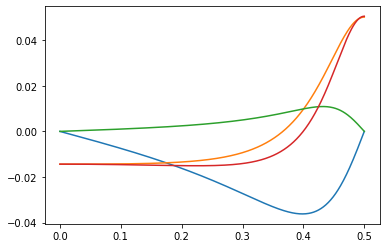

In [19]:
plt.plot(phi_exs,-g3s/2/np.pi)
plt.plot(phi_exs,12*g4s/2/np.pi)
plt.plot(phi_exs,-60*g5s/2/np.pi)
plt.plot(phi_exs,anhs/2/np.pi)
# plt.ylim(-0.05,0.05)

Text(0, 0.5, 'dressed Fock 1 energy (GHz)')

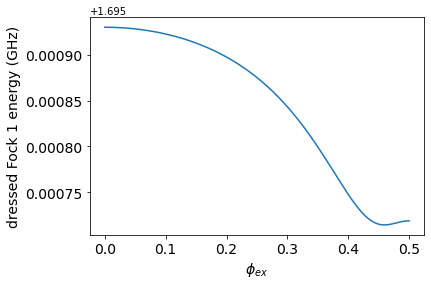

In [20]:
# plt.scatter(phi_exs[268],1.495)
plt.plot(phi_exs,Es)
plt.tick_params(axis='both', which='major', labelsize=14)  # Enlarge tick labels
plt.xlabel('$ϕ_{ex}$', fontsize=14)  # Enlarge x-axis label
plt.ylabel('dressed Fock 1 energy (GHz)', fontsize=14)  # Enlarge y-axis label
# plt.plot(phi_exs,omega_c/2/np.pi*np.ones(len(g_ints)) - g_ints/2/np.pi/(omega_ss/2/np.pi-omega_c/2/np.pi*np.ones(len(g_ints)))**2)
# plt.ylim(2.971,2.975)

In [21]:
phi_exs[np.argmin(np.abs(Es))]

0.45891783567134264

(0.01, 100)

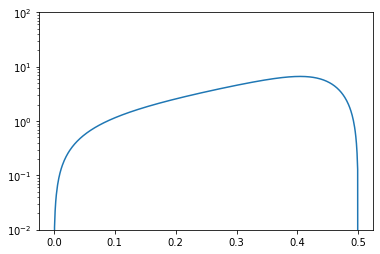

In [22]:
plt.plot(phi_exs,np.abs(sders))
plt.yscale('log')
plt.ylim(1e-2,100)

In [23]:
g3s[913]/2/np.pi

IndexError: index 913 is out of bounds for axis 0 with size 500